In [6]:
'''
New attempt at processing data

Goals: 
- Acknowledge the existence of 2 needed corrections 
    1. DC offset 
    2. Multiplier 

Methods: 
- Use S2c data to calculate for DC offset (curve fit) 
    Curve will take the form of y = a + exp(bx), note that this is not the actual equation but rather the 2DEG 
- Subtract DC offset from raw data and and multiply values with multiplier 
    After determining the value of a, apply (S2-a)*multiplier 
    Multiplier = S2c/S2 
- Return corrected data (apply best fit which should just be the exponential term in 2DEG)
''' 


'\nNew attempt at processing data\n\nGoals: \n- Acknowledge the existence of 2 needed corrections \n    1. DC offset \n    2. Multiplier \n\nMethods: \n- Use S2c data to calculate for DC offset (curve fit) \n    Curve will take the form of y = a + exp(bx), note that this is not the actual equation but rather the 2DEG \n- Subtract DC offset from raw data and and multiply values with multiplier \n    After determining the value of a, apply (S2-a)*multiplier \n    Multiplier = S2c/S2 \n- Return corrected data (apply best fit which should just be the exponential term in 2DEG)\n'

In [7]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import os
import os.path
from scipy.optimize import curve_fit

In [8]:
# Loading file, and obtaining long name components 
path = "./testfolder"
data_list = os.listdir(path) # Create a list of all files in the folder

current_file = data_list[2]
print(f"The file being used is {current_file}.")
components = current_file.split("_")
latticeT = components[0]

The file being used is 174_p200_n1_x_100_10nm_IT_10.csv.


In [9]:
# Constants to be used 
h = 4.1357 * 10 ** -15 # Plancks constant in eV*s
c = 2.99792458 * 10 ** 8 # Speed of light in m/s 
k = 8.617333262145 * 10 ** -5 # Boltzmann constant in eV/K
comp = 0.939162 # Composition for InGaAs, estimated by Peter, solved through Wolfram Alpha 

# User input 
wl = 1550*10**-9 # in m, wavelength of LED light
T = float(latticeT) + 273.15 # Lattice temperature, K 
bandE = 0.42+0.625*comp*(5.8/(T+300)-4.19/(T+271))*10**-4 * T**2 * comp - (4.19*10**-4 * T**2)/(T+271) + 0.475*comp**2 # in eV, bandgap energy for InGaAs. 
print(f"The band gap energy is {bandE}")


The band gap energy is 0.7435616030790153


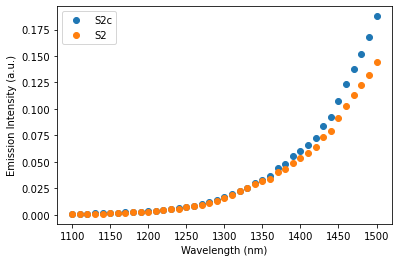

In [10]:
# Plot of raw S2c data to be used for ML
test_df = pd.read_csv(path+f"/{data_list[2]}") # For future uses, we will be doing 'for' loop for the entire directory, so there won't be a need to selectively choose the index 
col = test_df.columns # out: Index(['Wavelength', 'S2c', 'Wavelength.1', 'S2'], dtype='object')

# Creating new df to not mess with original 
new_df = pd.DataFrame() 
new_df[col[0]] = test_df[col[0]].iloc[1:] # Wavelength, using iloc to remove non numerical value 
new_df[col[1]] = test_df[col[1]].iloc[1:] # S2c 
new_df[col[3]] = test_df[col[3]].iloc[1:] # S2
new_df = new_df.astype(float) # Converting data values to numeric from strings, prep for parse in plot

# Introducing first correction factor, from dlambda to dE 
scale1 = 1500*10**-9/wl
new_df[col[1]] = new_df[col[1]] * scale1 # First correction S2c 
new_df[col[3]] = new_df[col[3]] * scale1 # First correction S2 

# Plot of raw S2c and S2 
plt.plot(new_df[col[0]], new_df[col[1]], 'o', label='S2c') # note that -o can be used to connect the dots 
plt.plot(new_df[col[0]], new_df[col[3]], 'o', label='S2')
plt.legend()
plt.ylabel('Emission Intensity (a.u.)')
plt.xlabel('Wavelength (nm)')
plt.show() 


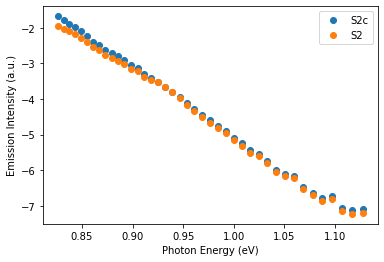

In [11]:
# Converting raw S2c to semi log plot of emission intensity against photon energy  (manually log data)
new_df['Photon Energy'] = (h*c)/(new_df[col[0]]*10**-9)
new_df['ln(S2c)'] = np.log(new_df[col[1]])
new_df['ln(S2)'] = np.log(new_df[col[3]])
plt.plot(new_df['Photon Energy'], new_df['ln(S2c)'], 'o', label='S2c')
plt.plot(new_df['Photon Energy'], new_df['ln(S2)'], 'o', label='S2')
plt.ylabel('Emission Intensity (a.u.)')
plt.xlabel('Photon Energy (eV)')
plt.legend()
plt.show()

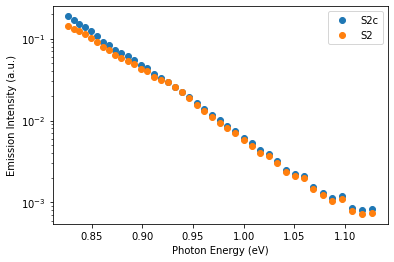

In [12]:
# Converting raw S2c to semi log plot of emission intensity against photon energy  (log scale with matplotlib)
new_df['Photon Energy'] = (h*c)/(new_df[col[0]]*10**-9)
plt.plot(new_df['Photon Energy'], new_df[col[1]], 'o', label='S2c')
plt.plot(new_df['Photon Energy'], new_df[col[3]], 'o', label='S2')
plt.ylabel('Emission Intensity (a.u.)')
plt.xlabel('Photon Energy (eV)')
plt.yscale('log')
plt.legend()
plt.show()

In [13]:
# Applying curve fit to S2c data to determine DC offset = a
def fit(E,a,b): 
    return E*np.sqrt(E-bandE)*np.exp(-E/(k*b)) # Eg and k are already defined previously 

E = np.linspace(0, 1.3,1000)
guess = np.array([10**-4, 174])
popt, pcov = curve_fit(fit, new_df['Photon Energy'], new_df[col[1]], maxfev = 5000) # note: col[1] is S2c column 

print(popt)
print(pcov)

[1. 1.]
[[inf inf]
 [inf inf]]
/Users/luke/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [14]:
# Applying curve fit to S2c data to determine DC offset = a
def ln_fit(E,a,b): 
    return a + 0.5*np.log(E-bandE)*(-E/(k*b)) # Eg and k are already defined previously 

E = np.linspace(0, 1.3,1000)

popt1, pcov1 = curve_fit(ln_fit, new_df['Photon Energy'], new_df['ln(S2c)'], maxfev = 5000) # note: col[1] is S2c column 

print(popt1)

[-13.42143267 961.18550766]


[1. 1.]


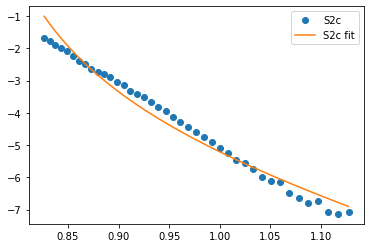

In [15]:
plt.plot(new_df['Photon Energy'], new_df['ln(S2c)'], 'o', label='S2c')
plt.plot(new_df['Photon Energy'], ln_fit(new_df['Photon Energy'], *popt1), '-', label='S2c fit')
# plt.yscale('log')
# plt.ylim(-1,1)
# plt.xlim(-1,3)
plt.legend()
plt.show()